In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db=mysql.connector.connect(host="localhost",username="root",password="Santoshmajhi668@",database="ecommerce")

cur=db.cursor()


# list all unique cities where customers are located.

In [2]:
query=""" select distinct customer_city from customers """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# count the number of orders placed in 2017.

In [3]:
query=""" select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# find the total sales per category.

In [4]:
query=""" select products.product_category as category,round(sum(payments.payment_value),2) as sales 
from products
join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""

cur.execute(query)
data=cur.fetchall()

data

[('perfumery', 506738.66),
 ('Furniture Decoration', 1430176.39),
 ('telephony', 486882.05),
 ('Fashion Bags and Accessories', 218158.28),
 ('bed table bath', 1712553.67),
 ('automotive', 852294.33),
 ('computer accessories', 1585330.45),
 ('housewares', 1094758.13),
 ('babies', 539845.66),
 ('toys', 619037.69),
 ('Furniture office', 646826.49),
 ('Cool Stuff', 779698.0),
 ('HEALTH BEAUTY', 1657373.12),
 ('pet Shop', 311268.97),
 ('General Interest Books', 64694.76),
 ('stationary store', 317440.07),
 ('Watches present', 1429216.68),
 ('PCs', 279121.55),
 ('climatization', 91170.66),
 ('Construction Tools Construction', 241475.63),
 ('sport leisure', 1392127.56),
 ('Bags Accessories', 187151.29),
 ('electronics', 259857.1),
 ('Casa Construcao', 136645.29),
 ('Games consoles', 195480.38),
 ('home appliances', 95532.27),
 ('Garden tools', 838280.75),
 ('Agro Industria e Comercio', 118730.61),
 (None, 252801.71),
 ('audio', 60324.62),
 ('technical books', 24915.44),
 ('Construction Tools 

# calculate the percentage of orders that were paid in installments.

In [5]:
query=""" select (sum(case when payment_installments >=1 then 1 else 0 end)) / count(*) *100 from payments """
cur.execute(query)
data=cur.fetchall()
data[0][0]

Decimal('99.9981')

# count number of orders from each state.

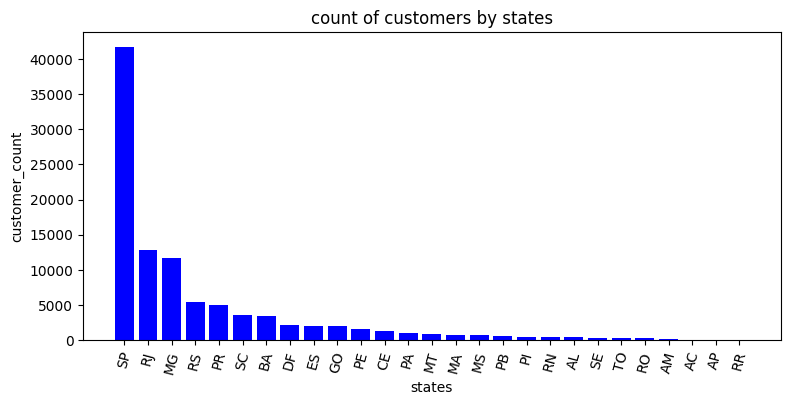

In [6]:
query=""" select customer_state, count(customer_id) from customers
group by customer_state """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)
plt.figure(figsize=(9,4))
plt.bar(df["state"],df["customer_count"],color="blue")
plt.xticks(rotation=75)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customers by states")
plt.show()

# calculate the number of orders per month in 2018.

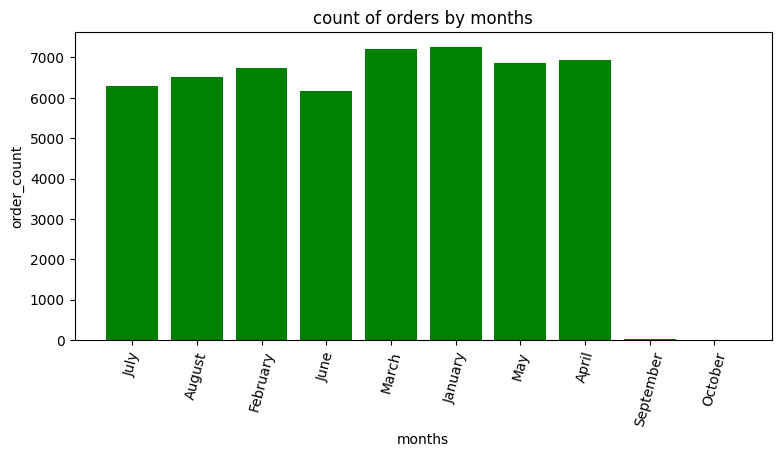

In [7]:
query=""" select monthname(order_purchase_timestamp) as months,count(order_id) as order_count
from orders
where year(order_purchase_timestamp)=2018
group by months """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
plt.figure(figsize=(9,4))
plt.bar(df["months"],df["order_count"],color="green")

plt.xticks(rotation=75)
plt.xlabel("months")
plt.ylabel("order_count")
plt.title("count of orders by months")
plt.show()

# find the average number of products per order, grouped by customer city.

In [8]:
query=""" with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as order_count
 from orders
 join order_items
 on orders.order_id=order_items.order_id
 group by orders.order_id,orders.customer_id)
 
 select customers.customer_city,round(avg(count_per_order.order_count),2) as average_orders
 from customers 
 join count_per_order
 on customers.customer_id=count_per_order.customer_id
 group by customers.customer_city
 order by average_orders"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["city","average_orders"])
df.head(10)

,city,average_orders
0,teresina de goias,1.00
1,santa maria do herval,1.00
2,patrocinio paulista,1.00
3,lagoa d'anta,1.00
4,panelas,1.00
5,caridade,1.00
6,erebango,1.00
7,botupora,1.00
8,nova esperanca do sudoeste,1.00
9,jiquirica,1.00


# calculate the percentage of total revenue contributed by each product category.

In [9]:
query=""" select upper(products.product_category) as category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) 
as sales_percentage from products
join order_items
on products.product_id= order_items.product_id
join payments
on payments.order_id= order_items.order_id
group by category
order by sales_percentage desc """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","percentage distribution"])
df.head()

,category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# identify the corelation between product price and number of times a product has been purchased.

In [10]:
query=""" select products.product_category as category, count(order_items.product_id),
round(avg(order_items.price),2) from products
join order_items
on products.product_id= order_items.product_id
group by category """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","order_count","price"])
arr1=df["order_count"]
arr2=df["price"]
ax=np.corrcoef([arr1,arr2])

print("the corelation is", ax[0][-1])

the corelation is -0.10631514167157562


# calculate the total revenue generated by each seller and rank them by revenue.

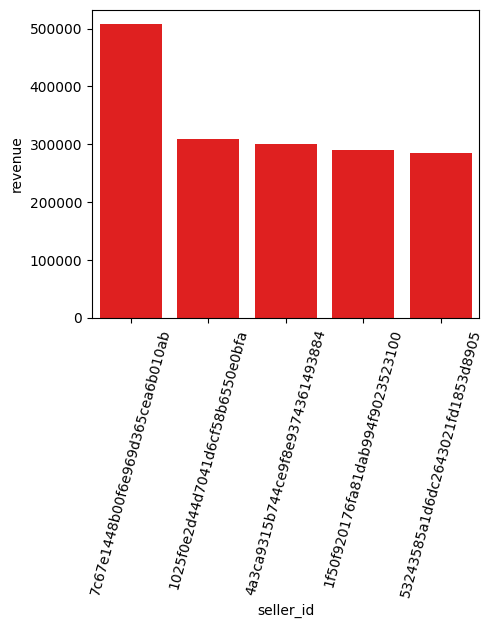

In [11]:
query=""" select *, dense_rank() over (order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
as revenue from order_items
join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
plt.figure(figsize=(5,4))
df=df.head()
sns.barplot(x="seller_id", y="revenue", data=df,color="red")
plt.xticks(rotation=75)
plt.show()


# calculate the moving average of order values for each customer over their order history.

In [12]:
query=""" select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_average
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments
join orders
on payments.order_id= orders.order_id) as a """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","order_purchase_timestamp","payment","moving_average"])
df.head()

,customer_id,order_purchase_timestamp,payment,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# calculate the cumulative sales per month for each year.

In [13]:
query=""" select years, months, payment, sum(payment) over(order by years, months) as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as years, 
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders
join payments
on orders.order_id= payments.order_id
group by years, months
order by years, months) as a """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","months","payment","cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69
5,2017,December,878401.48,2029948.17
6,2017,February,291908.01,2321856.18
7,2017,January,138488.04,2460344.22
8,2017,July,592382.92,3052727.14
9,2017,June,511276.38,3564003.52


# calculate the year-over-year growth rate of total sales.

In [14]:
query=""" with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders
join payments
on orders.order_id= payments.order_id
group by years
order by years)

select years,((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years))* 100 from a """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","year-over-year % growth"])
df

,years,year-over-year % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [15]:
query=""" with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from customers
join orders
on customers.customer_id= orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order
from a
join orders
on orders.customer_id= a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a 
left join b
on a.customer_id = b.customer_id """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0
0,None


# identify the top 3 customers who spent the most money in each year.

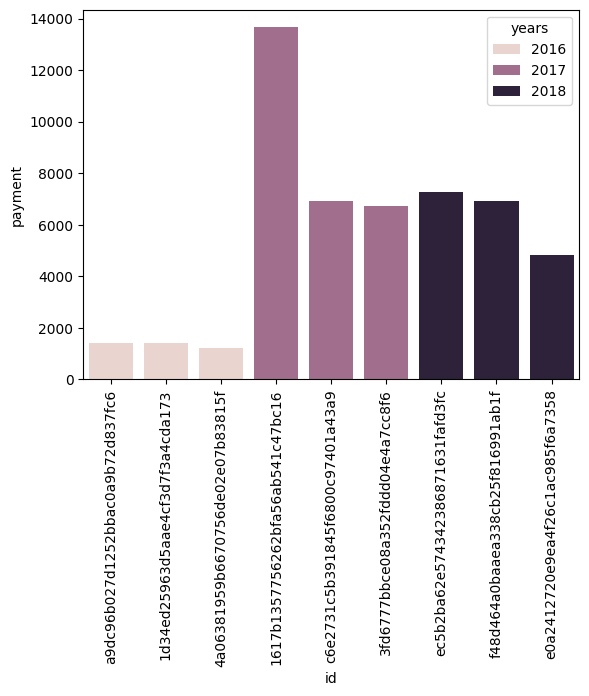

In [16]:
query=""" select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as d_rank
from orders 
join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3 """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","id","payment","rank"])
sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show()
